### BRAUX-GUILLIN Valentin <br/> École Polytechnique, January 2021

# Simulated Annealing for TSP

Simulated annealing is a probabilistic technique for approximating the global optimum of a non convex function. It is used here to solve a travelling salesman problem (TSP), i.e. finding the shortest possible path that visits exactly once all cities (here the US capitals, Hawaii and Alaska excluded).

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import *

## 1. Data

All data used in this problem comes from the [TSPLIB](http://elib.zib.de/pub/mp-testdata/tsp/tsplib/tsplib.html) library.

Coordinates of US capitals are extracted from a preprocessed CSV file, and the optimal route is stored in the list `uscapitals_opt`.

In [15]:
uscapitals_list = np.genfromtxt("uscapitals.csv", delimiter=",")
print(uscapitals_list[0])

[6734. 1453.]


In [16]:
uscapitals_opt = np.genfromtxt("uscapitals_opt.csv", delimiter=",").astype(np.int)-1
print(uscapitals_opt)

[ 0  7 37 30 43 17  6 27  5 36 18 26 16 42 29 35 45 32 19 46 20 31 38 47
  4 41 23  9 44 34  3 25  1 28 33 40 15 21  2 22 13 24 12 10 11 14 39  8]


In [17]:
def euclidian_dist(citya, cityb):
    return np.linalg.norm(cityb-citya)

uscapitals_distances = np.zeros((len(uscapitals_list),len(uscapitals_list)))

for i in range(len(uscapitals_list)):
    for j in range(len(uscapitals_list)):
        uscapitals_distances[i,j] = euclidian_dist(uscapitals_list[i], uscapitals_list[j])

In [18]:
cities = uscapitals_list
optimal = uscapitals_opt
distances = uscapitals_distances

## 2. Algorithm

The objective function is the cost $V$ of a path, defined as the sum of distances between consecutives cities. A path can be identified with a permutation $\sigma$ of the set $\{0,1,..,n\}$, represented as a list where $\sigma(k)$ is the $k$-th city visited by the path $\sigma$. Then it follows:

$$
V(\sigma) = \sum_{i=1}^{n-1} d(\sigma(i), \sigma(i+1)) + d(\sigma(n), \sigma(1)) 
$$

In [19]:
def V(tour, distances):
    
    if (tour.size <= 1):
        return 0
    
    c = 0
    n = tour.size
    
    for i in range(n-1):
        c += distances[tour[i],tour[i+1]]
    
    c += distances[tour[n-1],tour[0]]
    
    return c

At each step, the algorithm proposes a new path, obtained by choosing randomly two numbers $i$ and $j$ and switching the cities $\sigma(i)$ and $\sigma(j)$.

In [20]:
def proposition(tour):
    
    a = random.sample(list(tour),2)
    i,j = a[0],a[1]
    
    prop = tour.copy()
    prop[i],prop[j] = prop[j],prop[i]
    
    return prop

print("Example:", [0,1,2,3,4], "->", proposition([0,1,2,3,4]))

Example: [0, 1, 2, 3, 4] -> [4, 1, 2, 3, 0]


The path is either kept or rejected randomly, depending on the temperature. The first step is thus to set an annealing schedule for the decrease of the temperature. A simple start is to apply a polynomial decrease. Then the algorithm proceeds by switching cities step by step, depending on temperature and the gap between the costs of paths (the better the path, the higher the probability of keeping it). In the end, the algorithm returns the best path.

In [33]:
def T(i):
    return 300*((i+1)**(-0.03))

In [24]:
def simulated_annealing(distances, N_step, initial_tour, proposition, T):
    
    best = initial_tour
    tours = [initial_tour]
    costseq = [V(best,distances)]
    bestseq = [V(best,distances)]
    
    for i in range(N_step):
        
        Xi = tours[-1]
        y = proposition(Xi)
        U = np.random.rand(1)[0]
        a = np.exp((V(Xi,distances)-V(y,distances))/T(i))
        r = a/(1+a)
        
        if U <= r:
            tours += [y]
            costseq += [V(y,distances)]
        
        else:
            tours += [Xi]
            costseq += [V(Xi,distances)]
            
        if (V(y,distances) < V(best,distances)):
            best = y
        
        bestseq += [V(best,distances)]
        
    tour = tours[-1]
    
    return tour, best, costseq, bestseq

A list of initial paths is created by applying different numbers of random switches to the optimal path.

In [25]:
problem_initial_tours = []

for i in range(10):
    problem_initial_tours.append(optimal.copy())
    for k in range(i):
        problem_initial_tours[i] = proposition(problem_initial_tours[i])

In [26]:
N_step = 10000
i = 8
initial_tour = problem_initial_tours[i]

tour, best, cseq, bseq = simulated_annealing(distances, N_step, initial_tour, proposition, T)

In [27]:
def plot_recuit(cseq, bseq, best, optimal, legend=True, label=""):
    
    p1 = plt.axhline(V(optimal, distances), label="Optimal value", c="black", ls="--")
    p2, = plt.plot(cseq, label="V(X_n) "+label)
    p3, = plt.plot(bseq, label="V(Best_n) "+label)
    
    if legend:
        plt.legend(fontsize=12)
        plt.ylabel("Objective function", fontsize=12)
        plt.xlabel("Number of steps", fontsize=12)

Difference between the best cost found by the algorithm and the optimal cost is 6458.899702438655


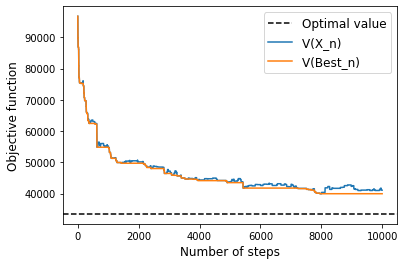

In [28]:
gap = V(best, distances) - V(optimal, distances)
print("Difference between the best cost found by the algorithm and the optimal cost is:", gap)
plot_recuit(cseq, bseq, best, optimal)

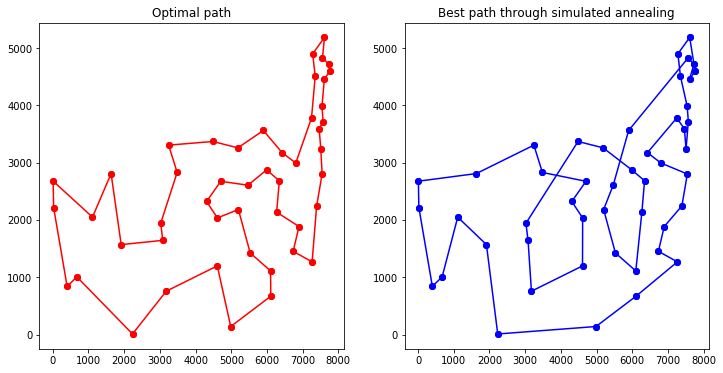

In [29]:
tt = optimal
total = len(cities)

plt.figure(figsize=(12,6))

plt.subplot(1, 2, 1)
plt.title("Optimal path")
for i in range(total-1):
    plt.plot(np.array([cities[tt[i], 0], cities[tt[i+1], 0]]),
             np.array([cities[tt[i], 1], cities[tt[i+1], 1]]), "-ro")
plt.plot(np.array([cities[tt[total-1], 0], cities[tt[0], 0]]), np.array(
    [cities[tt[total-1], 1], cities[tt[0], 1]]), "-ro")

plt.subplot(1, 2, 2)
plt.title("Best path through simulated annealing")
for i in range(total-1):
    plt.plot(np.array([cities[best[i], 0], cities[best[i+1], 0]]),
             np.array([cities[best[i], 1], cities[best[i+1], 1]]), "-bo")
plt.plot(np.array([cities[best[total-1], 0], cities[best[0], 0]]), np.array(
    [cities[best[total-1], 1], cities[best[0], 1]]), "-bo")

plt.show()

## 3. Path proposal

In the previous part, path proposal only consisted in switching two cities chosen randomly. Other types of proposals are possible, for example a path obtained by choosing two cities randomly, switching them and reversing all the cities between them.

In [34]:
def proposition_reverse(tour):
    
    a = random.sample(list(tour),2)
    i,j = a[0],a[1]
    i,j = min(i,j),max(i,j)
    
    prop = tour.copy()
    for k in range(j-i+1):
        prop[i+k] = tour[j-k]
    
    return prop

print("Example:", [0,1,2,3,4,5,6], "->", proposition_reverse([0,1,2,3,4,5,6]))

Example: [0, 1, 2, 3, 4, 5, 6] -> [0, 6, 5, 4, 3, 2, 1]


Difference between the best cost found by the algorithm and the optimal cost is: 3757.897269222369


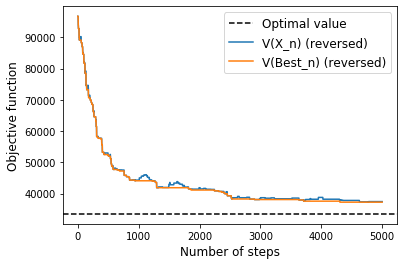

In [35]:
tour, best, cseq, bseq = simulated_annealing(distances, 5000, initial_tour, proposition_reverse, T)
gap = V(best, distances) - V(optimal, distances)
print("Difference between the best cost found by the algorithm and the optimal cost is:", gap)
plot_recuit(cseq, bseq, best, optimal, label="(reversed)")

The algorithm can be improved by fostering the switch of close cities. For example, given the $i$-th city, the $j$-th city is chosen with probability $\frac{C}{|i-j|+1}$.

In [36]:
def proposition_reverse_weighted(tour):
    
    n = len(list(tour))
    i = random.randint(0,n-1)
    
    p = []
    for j in range(n):
        p += [1/(abs(i-j)+1)]
    
    p[i] = 0
    p = np.asarray(p)/sum(p)
    
    j = np.random.choice(tour,1,list(p))
    j = int(j)
    i,j = min(i,j),max(i,j)
    
    prop = tour.copy()
    for k in range(j-i+1):
        prop[i+k] = tour[j-k]
    
    return prop

print("Example:", [0,1,2,3,4,5,6], "->", proposition_reverse_weighted([0,1,2,3,4,5,6]))

Example: [0, 1, 2, 3, 4, 5, 6] -> [0, 1, 6, 5, 4, 3, 2]


Difference between the best cost found by the algorithm and the optimal cost is: 3939.769168587365


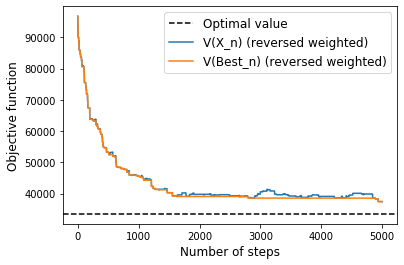

In [37]:
tour, best, cseq, bseq = simulated_annealing(distances, 5000, initial_tour, proposition_reverse_weighted, T)
gap = V(best, distances) - V(optimal, distances)
print("Difference between the best cost found by the algorithm and the optimal cost is:", gap)
plot_recuit(cseq, bseq, best, optimal, label="(reversed weighted)")

The improvement of the algorithm can be seen with multiple trials of both methods.

In [38]:
gaps_reverse = []
for _ in range(50):
    tour, best, cseq, bseq = simulated_annealing(distances, 5000, initial_tour, proposition_reverse, T)
    gap = V(best, distances) - V(optimal, distances)
    gaps_reverse.append(gap)

In [39]:
gaps_reverse_weighted = []
for _ in range(50):
    tour, best, cseq, bseq = simulated_annealing(distances, 5000, initial_tour, proposition_reverse_weighted, T)
    gap = V(best, distances) - V(optimal, distances)
    gaps_reverse_weighted.append(gap)

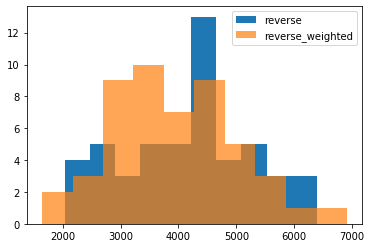

In [40]:
plt.hist(gaps_reverse ,label="reverse")
plt.hist(gaps_reverse_weighted, label="reverse_weighted", alpha=0.7)
plt.legend()
plt.show()

## 4. Annealing schedule

Trying several annealing schedule is considered to be a fine way to find a good one.

In [41]:
def T_polynomial(a, b):
    def T(i):
        return a*((i+1)**b)
    return T

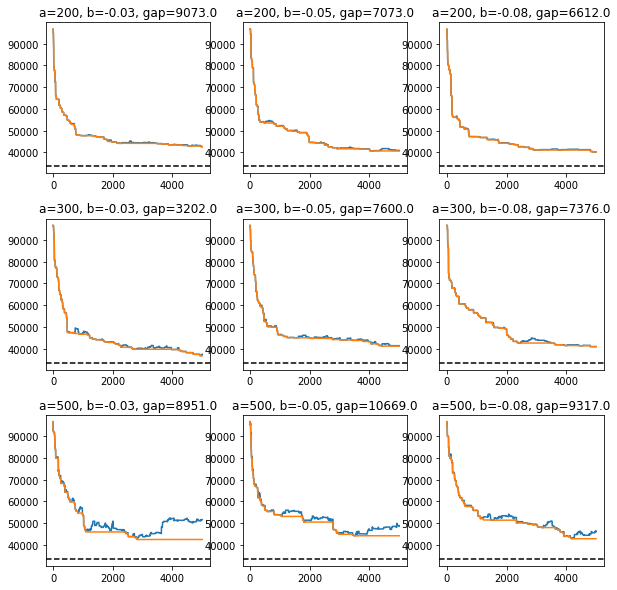

In [42]:
plt.figure(figsize=(10,10))
plt.subplots_adjust(hspace=0.3)

i = 1
for a in [200, 300, 500]:
    for b in [-0.03, -0.05, -0.08]:
        T = T_polynomial(a, b)
        tour, best, cseq, bseq = simulated_annealing(distances, 5000, initial_tour, proposition, T)
        gap = V(best, distances) - V(optimal, distances)
        plt.subplot(3,3,i)
        plt.title("a={}, b={}, gap={}".format(a,b,round(gap)))
        plot_recuit(cseq, bseq, best, optimal, legend=False)
        i += 1
        
plt.show()

In [43]:
def T_exponential(a, b):
    def T(i):
        return a*(b**i)
    return T

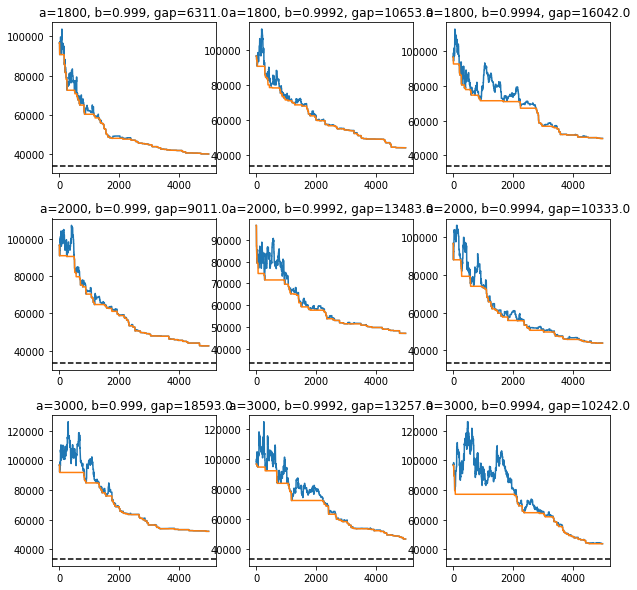

In [45]:
plt.figure(figsize=(10,10))
plt.subplots_adjust(hspace=0.3)

i = 1
for a in [1800, 2000, 3000]:
    for b in [0.999, 0.9992, 0.9994]:
        T = T_exponential(a, b)
        tour, best, cseq, bseq = simulated_annealing(distances, 5000, initial_tour, proposition, T)
        gap = V(best, distances) - V(optimal, distances)
        plt.subplot(3,3,i)
        plt.title("a={}, b={}, gap={}".format(a,b,round(gap)))
        plot_recuit(cseq, bseq, best, optimal, legend=False)
        i += 1

plt.show()

It can also be a good idea to have a non strictly decreasing annealing, to escape local minima.

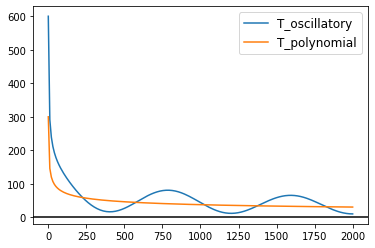

In [47]:
def T_oscillatory(a, b, c, d):
    def T(i):
        return a*((i+1)**b)*(np.cos(2*np.pi*i/c)**2 + d)
    return T

x = np.linspace(0,2000,200)
plt.plot(x, T_oscillatory(500,-0.3,1600,0.2)(x), label="T_oscillatory")
plt.plot(x, T_polynomial(300,-0.3)(x), label="T_polynomial")
plt.axhline(0, c="black")
plt.legend(fontsize=12)
plt.show()

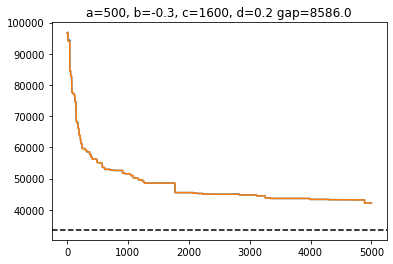

In [49]:
a,b,c,d = 500,-0.3,1600,0.2
T = T_oscillatory(a,b,c,d)
tour, best, cseq, bseq = simulated_annealing(distances, 5000, initial_tour, proposition, T)
gap = V(best, distances) - V(optimal, distances)
plt.title("a={}, b={}, c={}, d={} gap={}".format(a,b,c,d,round(gap)))
plot_recuit(cseq, bseq, best, optimal, legend=False)

plt.show()